In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import numpy as np

In [22]:
from telemetry.models.periodogram import frequencies
import astropy.units as u

In [118]:
def bode_plot(transfer_data, freq, sym=True, **kwargs):
    """Helper function for making bode plots."""
    plt.plot(freq, transfer_data, **kwargs)
    if sym:
        plt.plot(-freq, transfer_data, **kwargs)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.5, freq.max().value)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"$\left|\textrm{Power}\right|^{2}$")

## Load Data
We will be working with a stacked periodogram of slopes, using the default control matrix, with a gain setting of 0.2

In [119]:
file = h5py.File(os.path.expanduser("~/Documents/Telemetry/telemetry_2016-03-22_s0156.hdf5"))
tf = file['/transferfunction/hcoefficients/data']

In [120]:
transfer_functions = tf[...]
rate = 250 * u.Hz
freq = frequencies(transfer_functions.shape[0], rate)

Here are all of the transfer functions we have to work with. There are 224 transfer functions (one for each WFS mode)

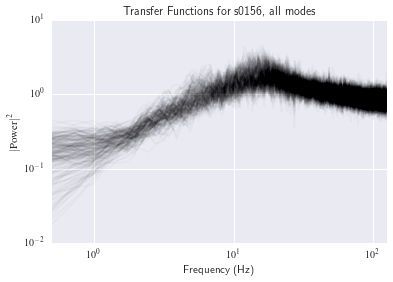

In [121]:
bode_plot(transfer_functions, freq, alpha=0.01, c='k')
plt.ylim(1e-2, 10)
plt.title("Transfer Functions for s0156, all modes")

By selecting only the first 20 modes, we can look at system performance in the low-order case. The modes are roughly ordered by spatial frequency.

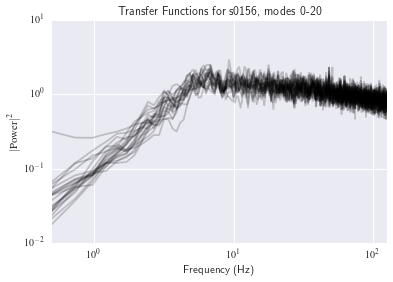

In [122]:
bode_plot(transfer_functions[:,:20], freq, alpha=0.1, c='k')
plt.ylim(1e-2, 10)
plt.title("Transfer Functions for s0156, modes 0-20")

To make fitting a little simpler (and maybe less realistic), we will combine the first 20 modes into a single, less-noisy, transfer function.

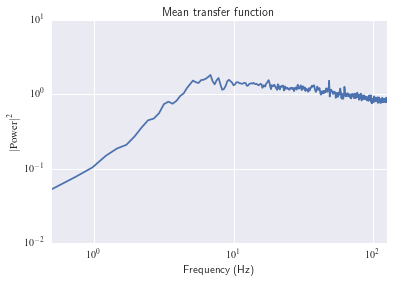

In [123]:
stf = transfer_functions[:,:20].mean(axis=1)
bode_plot(stf, freq, sym=False)
plt.ylim(1e-2, 10)
plt.title("Mean transfer function")

## A model transfer function
We'll now build a model of our transfer function, assuming a stare time for the WFS, a hold time for the DM, and an arbitrary delay, \\(\tau\\). Assuming a control period \\(T\\), gain \\(g\\) and integrator constant (bleed) \\(c\\), the delay contribution is given by:

\\[ \textrm{d} = \left(\frac{1 - \exp\left(-2\pi i f T\right)}{2\pi i f T}\right)^2 \exp\left(-2\pi i f \tau\right)\\]

The full transfer function is:

\\[ C(z) = \frac{g}{1 - c z^{-1}} \\]

\\[ ETF(f) = \left(\frac{1}{1 + d C(z)}\right)^{2} \\]

We'll implement a model transfer function using astropy modeling. It will return \\(\log ETF(f)\\) for fitting in log space.

In [124]:
from astropy.modeling import FittableModel, Parameter
class TransferFunction(FittableModel):
    """Model of a transfer function."""
    
    inputs = ('freq',)
    outputs = ('y',)
    
    tau = Parameter(min=0.0)
    gain = Parameter(min=0.0, max=1.0)
    integrator = Parameter(min=1e-5, max=1.0 - 1e-3)
    rate = Parameter(fixed=True)
    
    @staticmethod
    def evaluate(freq, tau, gain, integrator, rate):
        """Evaluate a transfer function."""
        
        s = 1j * 2.0 * np.pi * freq
        bigT = 1.0 / rate
        
        sz = (s == 0)
        denom = (bigT * s)
        
        denom[sz] = 1.0
        
        hdw_cont = (1.0 - np.exp(-(bigT * s))) / denom
        hdw_cont[sz] = 1.0
        
        delay_cont = np.exp(-1.0 * tau * s)
        delay_term = delay_cont * hdw_cont * hdw_cont
        
        zinv = np.exp(-1.0 * bigT * s)
        cofz = gain / (1.0 - integrator * zinv)
        
        return np.log(np.abs(1.0 / (1.0 + delay_term * cofz)**2.0))

To demonstrate that this works, pick some reasonable parameters for our system, and plot the transfer function:

In [125]:
model = TransferFunction(tau=0.004, rate=250, integrator=0.995, gain=0.2)
print(model)

Model: TransferFunction
Inputs: ('freq',)
Outputs: ('y',)
Model set size: 1
Parameters:
     tau  gain integrator  rate
    ----- ---- ---------- -----
    0.004  0.2      0.995 250.0


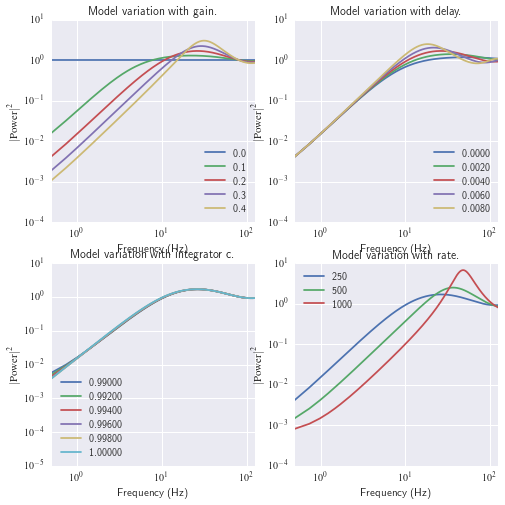

In [126]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
for gain in np.arange(0, 0.5, 0.1):
    model.gain = gain
    bode_plot(np.exp(model(freq.value)), freq, sym=False, label="{:.1f}".format(gain))
plt.legend(loc='best')
plt.title("Model variation with gain.")
plt.subplot(2,2,2)
model.gain = 0.2
for tau in np.arange(0, 0.01, 0.002):
    model.tau = tau
    bode_plot(np.exp(model(freq.value)), freq, sym=False, label="{:.4f}".format(tau))
plt.legend(loc='best')
plt.title("Model variation with delay.")
model.tau = 0.004
plt.subplot(2,2,3)
for integrator in np.arange(0.99, 1.0, 0.002):
    model.integrator = integrator
    bode_plot(np.exp(model(freq.value)), freq, sym=False, label="{:.5f}".format(integrator))
plt.legend(loc='best')
plt.title("Model variation with integrator c.")
model.integrator = 0.995
plt.subplot(2,2,4)
for rate in [250, 500, 1000]:
    model.rate = rate
    bode_plot(np.exp(model(freq.value)), freq, sym=False, label="{:.0f}".format(rate))
plt.legend(loc='best')
plt.title("Model variation with rate.")
model.rate = 250

Now we can try fitting our transfer function model to data. We'll use a least-squares fit in log-log space

In [127]:
from astropy.modeling import fitting
fitter = fitting.LevMarLSQFitter()

In [128]:
ly = np.log(stf)
x = freq
model_init = TransferFunction(tau=1.0/250, rate=250, integrator=0.995, gain=0.2)
model_conly = TransferFunction(tau=936e-6, rate=250, integrator=0.995, gain=0.2)
model = fitter(model_init, x, ly, maxiter=1000)
print(model)

Model: TransferFunction
Inputs: ('freq',)
Outputs: ('y',)
Model set size: 1
Parameters:
          tau              gain        integrator    rate
    ---------------- --------------- -------------- -----
    0.00620377307163 0.0664905381418 0.988192157637 250.0


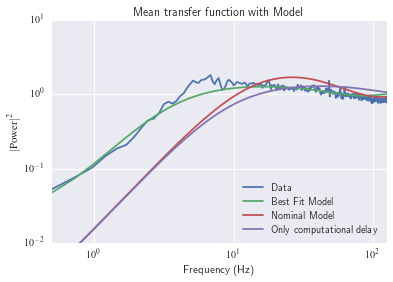

In [130]:
bode_plot(stf, freq, sym=False, label="Data")
bode_plot(np.exp(model(freq.value)), freq, sym=False, label="Best Fit Model")
bode_plot(np.exp(model_init(freq.value)), freq, sym=False, label="Nominal Model")
bode_plot(np.exp(model_conly(freq.value)), freq, sym=False, label="Only computational delay")
plt.ylim(1e-2, 10)
plt.title("Mean transfer function with Model")
plt.legend(loc='lower right')

This fit is pretty good, with overall low residuals except at the overshoot point. I've also plotted the nominal model and the nominal model but with only a computational delay, and you can see that they don't seem to match the data very well.

## Comparison to Don's models

The only difference between my models and Don's models appears to be whether we are examining the power squared, or just the power. My periodograms always return the power squared, and the model is squared to reflect that. Don's model is not squared, and I presume his periodograms might not be squared. The differnece is shown below.

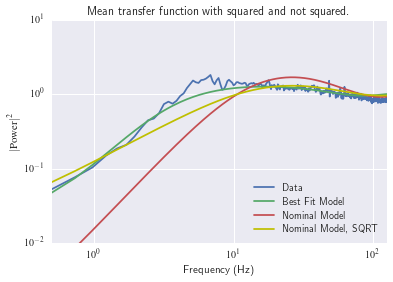

In [134]:
bode_plot(stf, freq, sym=False, label="Data")
bode_plot(np.exp(model(freq.value)), freq, sym=False, label="Best Fit Model")
bode_plot(np.exp(model_init(freq.value)), freq, sym=False, label="Nominal Model")
bode_plot(np.sqrt(np.exp(model_init(freq.value))), freq, sym=False, label="Nominal Model, SQRT", color="y")

plt.ylim(1e-2, 10)
plt.title("Mean transfer function with squared and not squared.")
plt.legend(loc='lower right')

You can see the not-squared model, for the nominal gain (0.2) which does appear to visually match the data better in this case, but the power law slope in the gain region is clearly wrong. This leads me to believe that indeed my squared periodograms are functioning correctly.